# Проект A/B-тестирования

### Описание

Задача — провести оценку результатов A/B-теста. В моём распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

### Техническое задание

Техническое задание

Название теста: recommender_system_test;

Группы: А (контрольная), B (новая платёжная воронка);

Дата запуска: 2020-12-07;

Дата остановки набора новых пользователей: 2020-12-21;

Дата остановки: 2021-01-04;

Аудитория: 15% новых пользователей из региона EU;

Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

Ожидаемое количество участников теста: 6000.

Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:

конверсии в просмотр карточек товаров — событие product_page

просмотры корзины — product_cart

покупки — purchase.

### Задачи

1)Подключение библиотек, выгрузка, осмотр данных

2)Подготовка, предобработка данных

3)Оценка корректности проведения теста

3.1)Проверка пользователей попавших в обе группы

3.2)Проверка распределения пользователей по региону и устройствам регистрации

3.3)Проверка времени проведения теста на совпадение с маркетинговыми событиями

4)Проведение исследования

4.1)Количество событий на пользователя и нормальность распределения в выборках по дням

4.2)Распределение пользователей по датам регистрации

4.3)Количество событий на пользователя распределённые по эвентам

4.4)Построение воронки для группы А

4.5)построение воронки для группы B

5)А/B тест



## Подключение библиотек, выгрузка и осмотр данных

In [63]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math as mth
from scipy import stats as st
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [64]:
ab_marketing_events = pd.read_csv('/Users/Риндикт/notebook/raw_data_ab_test/ab_project_marketing_events.csv')
final_ab_new_users = pd.read_csv('/Users/Риндикт/notebook/raw_data_ab_test/final_ab_new_users.csv')
final_ab_events = pd.read_csv('/Users/Риндикт/notebook/raw_data_ab_test/final_ab_events.csv')
final_ab_participants = pd.read_csv('/Users/Риндикт/notebook/raw_data_ab_test/final_ab_participants.csv')

In [65]:
ab_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [66]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [67]:
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [68]:
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Подключил библиотеки, и вывел данные на экран

## Предобработка данных

Создаю функцию для обработки датасетов что бы избежать дублирования кода

In [69]:
def info(data):
    ''' 
    функция для предварительной обработки датасетов
    '''
    
    print("Дубликатов обнаружено: ", data.duplicated().sum())
    if data.duplicated().sum() >0:
        print('Обнаружены дубликаты, произвожу очистку')
        data = data.drop_duplicates()
        print('Дубликаты ',data.duplicated().sum())
    print()
    print('Пропусков обнаружено:', data.isna().sum())
    print()
    data.info()
    return data

In [70]:
ab_marketing_events = info(ab_marketing_events)

Дубликатов обнаружено:  0

Пропусков обнаружено: name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [71]:
final_ab_new_users = info(final_ab_new_users)

Дубликатов обнаружено:  0

Пропусков обнаружено: user_id       0
first_date    0
region        0
device        0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [72]:
final_ab_events = info(final_ab_events)

Дубликатов обнаружено:  0

Пропусков обнаружено: user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [73]:
final_ab_participants = info(final_ab_participants)

Дубликатов обнаружено:  0

Пропусков обнаружено: user_id    0
group      0
ab_test    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Преобразую типы данных для дальнейшей работы

In [74]:
ab_marketing_events.start_dt = pd.to_datetime(ab_marketing_events.start_dt)
ab_marketing_events.finish_dt = pd.to_datetime(ab_marketing_events.finish_dt)
final_ab_new_users.first_date = pd.to_datetime(final_ab_new_users.first_date)
final_ab_events.event_dt = pd.to_datetime(final_ab_events.event_dt)

Создаю таблицу пользователей

In [75]:
full_tabl =  final_ab_participants.merge(final_ab_new_users, how = 'left', on = 'user_id')
full_tabl = full_tabl.merge(final_ab_events, how = 'left', on ='user_id' )
full_tabl['event_data'] = full_tabl.event_dt.dt.floor('D')

Проверяю полученую таблицу

In [76]:
full_tabl = info(full_tabl)

Дубликатов обнаружено:  0

Пропусков обнаружено: user_id           0
group             0
ab_test           0
first_date        0
region            0
device            0
event_dt       3743
event_name     3743
details       94952
event_data     3743
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110368 entries, 0 to 110367
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     110368 non-null  object        
 1   group       110368 non-null  object        
 2   ab_test     110368 non-null  object        
 3   first_date  110368 non-null  datetime64[ns]
 4   region      110368 non-null  object        
 5   device      110368 non-null  object        
 6   event_dt    106625 non-null  datetime64[ns]
 7   event_name  106625 non-null  object        
 8   details     15416 non-null   float64       
 9   event_data  106625 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1),

Удаляю пользователей у которых нету не даты эвента не названия эвента так как мы не сможем по ним строить графики

In [77]:
full_tabl_one = full_tabl.dropna(subset=['event_dt'])
full_tabl_one['event_TTL'] = (full_tabl_one['event_dt']-full_tabl_one['first_date']).dt.days
full_tabl = full_tabl_one.query('event_TTL <15')

C:\Users\Риндикт\AppData\Local\Temp\ipykernel_12280\2244401042.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Отбираю пользователей только по интересующему нас A/B тесту

In [78]:
full_tabl =full_tabl.query('ab_test == "recommender_system_test"')

### Итог

Проверил данные на дубликаты и пропуски (в имени эвента и начале его старта я полагаю это люди не участвовавшие в нашем тесте, а в details это стоимость покупки, но у нас не в каждом событии происходить покупка от того и пропуски), удалил пользователей не участвовавших в a/b тестировании, но попавших в таблицы, отобрал пользователей только по интересующему нас аб тесту, привёл типы данных к нужным для дальнейшего использования

## Оценка корректности проведение теста

### Ищу пользователей попавших в обе группы

In [79]:
full_tabl.groupby('user_id').agg({'group':'nunique'}).query('group>1')

,group
user_id,


### Проверяю распределение пользователей по региону

In [80]:
full_tabl.pivot_table(index = 'region',columns= 'group', values = 'user_id', aggfunc = 'nunique')

group,A,B
region,,
APAC,28,17
CIS,19,11
EU,2604,877
N.America,96,23


### Проверяю долю пользователей, которые участвовали в тесте из Евросоюза, от общего числа пользователей из этого региона

In [81]:
chislitel =  final_ab_participants.merge(final_ab_new_users, on = 'user_id', how = 'left')\
.query('ab_test == "recommender_system_test" and region == "EU"')
znamenal = final_ab_new_users.query('first_date <= "2020-12-21" and region == "EU"')
len(chislitel)/len(znamenal)


0.15

 15% пользователей из европпы нас это устраивает

### Проверяю распределения пользователей по устройствам регистрации

In [82]:
full_tabl.pivot_table(index = 'device',columns= 'group', values = 'user_id', aggfunc = 'nunique')

group,A,B
device,,
Android,1197,428
Mac,270,76
PC,726,227
iPhone,554,197


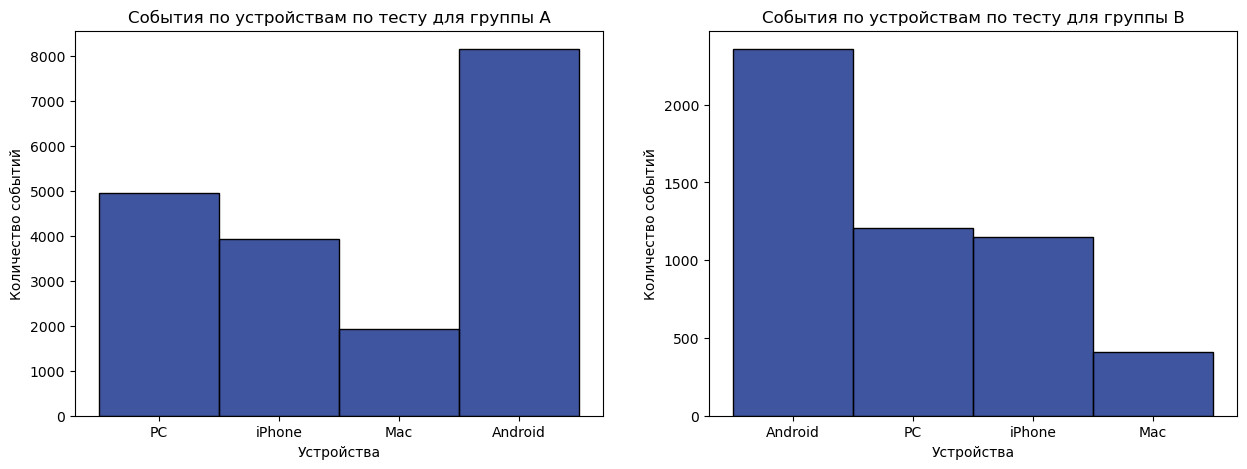

In [83]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.histplot(full_tabl.query('group == "A"'), x = 'device')
plt.xlabel('Устройства')
plt.ylabel('Количество событий')
plt.title("События по устройствам по тесту для группы A")
plt.subplot(1, 2, 2)
sns.histplot(full_tabl.query('group == "B"'), x = 'device')
plt.xlabel('Устройства')
plt.ylabel('Количество событий')
plt.title("События по устройствам по тесту для группы B")
plt.show()

### Проверяю что тест не совпадает с маркетинговыми событиями

In [84]:
min_date = full_tabl.event_dt.min()
max_data = full_tabl.event_dt.max()
ab_marketing_events.query('start_dt >@min_date and start_dt< @max_data')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


In [85]:
min_date

Timestamp('2020-12-07 00:05:57')

Два маркетинговых события пересекаются с нашим исследованием в последние 5 дней и если CIS New Year Gift Lottery не как не повлияет так как идёт в регионе где пользователей почти нет то Christmas&New Year Promo могут так как в оно проходит в самом активном нашем регионе

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №1__

События, праздники и тп - влияют на две группы одинаково. Это просто изменение качества пользователей, но относительную конверсию группы В к группе А - не будет иметь воздействие. Но это нужно учитывать при изучении абсолютных данных.
</div>

### Проверяю попали ли пользователи из моего аб теста в другой и если да, в каких группах они там находятся

In [86]:
final_ab_new_users = final_ab_new_users[final_ab_new_users['first_date'] <= '2020-12-21 00:00:00']
final_ab_new_users = final_ab_new_users[final_ab_new_users['region'] == 'EU']
data = final_ab_new_users.merge(final_ab_participants, on='user_id', how='left').dropna()
data_new = data.query('ab_test=="recommender_system_test"& region == "EU"')
test_intersection = (data_new['user_id'].reset_index().merge(
 final_ab_participants[final_ab_participants['ab_test'] == 'interface_eu_test']['user_id'].reset_index(),
     how='inner', on='user_id'))

In [87]:
test_interface = (data_new['user_id'].reset_index()\
                  .merge(final_ab_participants.query('ab_test == "interface_eu_test"').user_id.reset_index(),\
                         how = 'inner',on = 'user_id'))
print('Количество пересекающихся пользователей в обоих тестах: {}'.format(len(test_interface)))

Количество пересекающихся пользователей в обоих тестах: 1602


In [88]:
print('{:.2%} пользователей участвовали в обоих тестах'.format(len(test_intersection)/len(data_new.user_id)))

25.22% пользователей участвовали в обоих тестах


### Смотрю как распределены папавшие в группу B теста interface_eu_test в моём аб тесте

In [89]:
print(test_intersection.merge(final_ab_participants[final_ab_participants['ab_test'] == "recommender_system_test"][['user_id', 'group']],\
                              how = 'left',on = 'user_id')['group'].\
      value_counts()/ (data_new.merge(final_ab_participants[final_ab_participants['ab_test'] == "recommender_system_test"][['user_id','group']]))['group'].value_counts())

A    0.253440
B    0.250644
Name: group, dtype: float64


Пользователи распределены равномерно по группам и результаты не исказяться

### Итог

Пользователи в группах не пересекаются, группы не равномерны в группе, а пользователей больше в 2 и более раза, что может сказаться на дальнейшем исследовании, так же тест под конец пересекается с маркетинговыми событиями

## Исследование данных

### Число событий в выборках распределено по дням

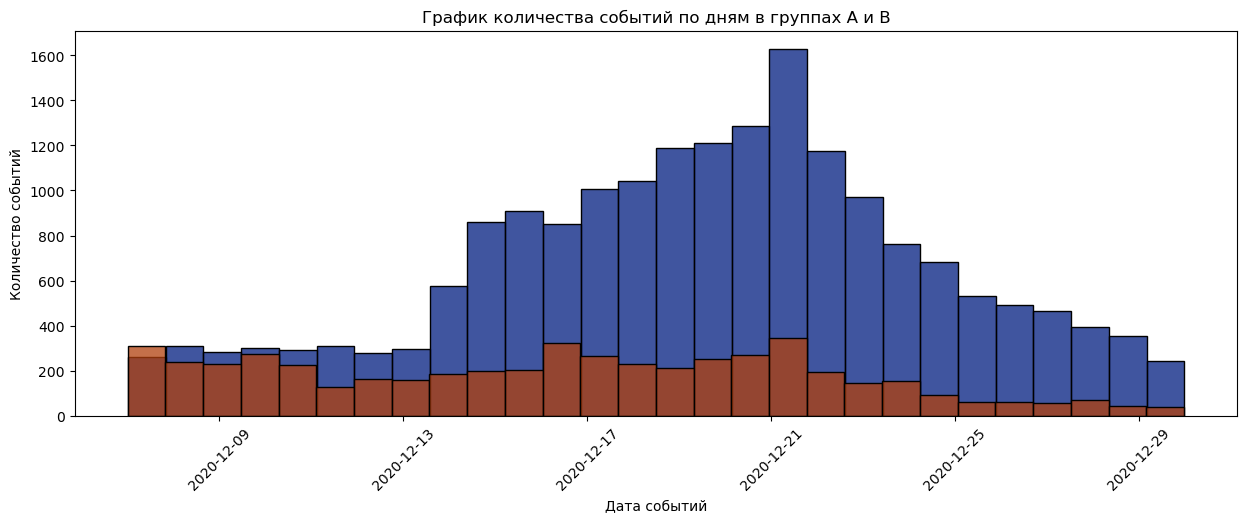

In [90]:
sns.set_palette('dark') 
plt.figure(figsize=(15,5))
sns.histplot(full_tabl.query('group == "A"'), x = 'event_dt',bins=28)
plt.xlabel('Дата событий')
plt.ylabel('Количество событий')
plt.title('График количества событий по дням в группах А и B')
plt.xticks(rotation = 45)
sns.histplot(full_tabl.query('group == "B"'), x = 'event_dt',bins=28)
plt.show()

На графике мы видим что группы не сбалансированы, в группе B событий намного меньше, большой приток событий после 14-го числа возможно это связано с большим количеством в данной группе вероятно пришедших в этот момент, после 30го числа в группах событий не наблюдаю вовсе Так же в группе B среднее количество событий на пользователя ниже

In [91]:
print('Среднее количество событий на пользователя в группе А: ',round(full_tabl.query('group == "A"').event_name.count()/full_tabl.query('group == "A"').user_id.nunique(),2))
print('Среднее количество событий на пользователя в группе В: ',round(full_tabl.query('group == "B"').event_name.count()/full_tabl.query('group == "B"').user_id.nunique(),2))

Среднее количество событий на пользователя в группе А:  6.9
Среднее количество событий на пользователя в группе В:  5.52


### График распределения между группами по датам регистрации пользователей 

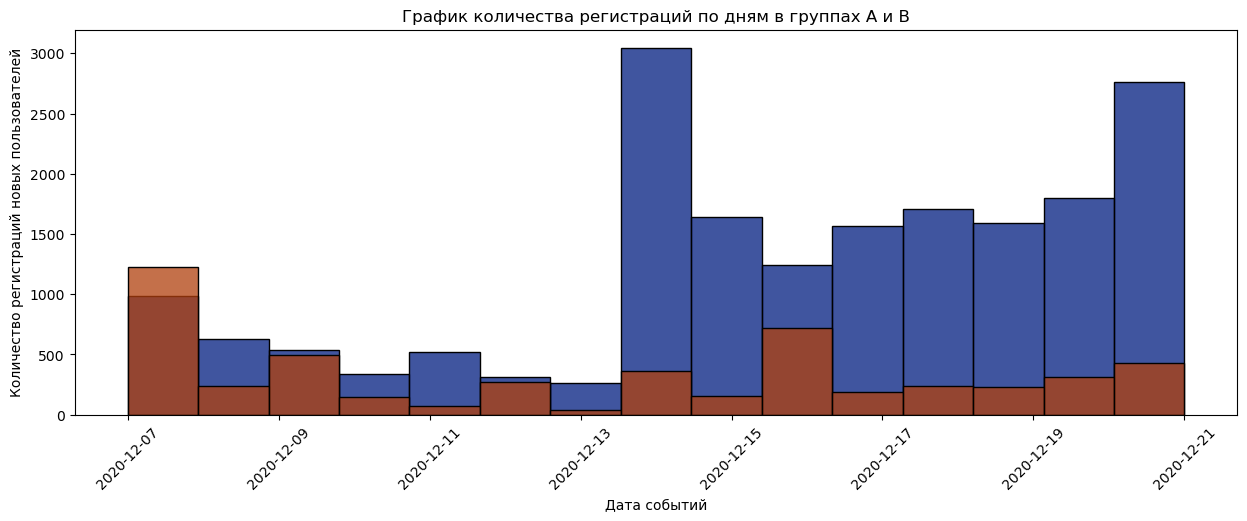

In [92]:
plt.figure(figsize=(15,5))
sns.histplot(full_tabl.query('group == "A"'), x = 'first_date',bins=15)
plt.xlabel('Дата событий')
plt.ylabel('Количество регистраций новых пользователей')
plt.title('График количества регистраций по дням в группах А и В')
sns.histplot(full_tabl.query('group == "B"'), x = 'first_date',bins=15)
plt.xticks(rotation = 45)

plt.show()

На графике мы видим что группы не сбалансированы, в группе B регистраций намного меньше, а в группу А пришло много пользователей после 13го числа что и объясняет увеличившееся количество событий

### Количество событий на пользователя распределеные по эвентам

In [93]:
full_tabl.pivot_table(index = 'event_name',columns= 'group', values = 'user_id', aggfunc = 'nunique')

group,A,B
event_name,,
login,2747,927
product_cart,824,255
product_page,1780,523
purchase,872,256


Критичных различий не наблюдаю

### Изменение конверсии в воронке в выборках на разных этапах для группы А

In [94]:
fig = go.Figure(go.Funnel(y = ['login','product_page','product_cart','purchase'],
                          x = [2747,1780,824,872],
                          
                          textposition = 'inside',
                          textinfo = 'value + percent previous'))
fig.update_layout(title='Воронка событий группы A',yaxis_title='События в воронке', title_x = 0.5)
fig.show()

### Изменение конверсии в воронке в выборках на разных этапах для группы B

In [95]:
fig = go.Figure(go.Funnel(y = ['login','product_page','product_cart','purchase'],
                          x = [927,523,255,256],
                          
                          textposition = 'inside',
                          textinfo = 'value + percent previous'))
fig.update_layout(title='Воронка событий группы B',yaxis_title='События в воронке', title_x = 0.5)
fig.show()

Я считаю тут тоже неровная воронка в низу от того что можно миновать продуктовую корзину и сразу купить продукт

### Итог и что нужно учесть в дальнейшем

Изучив данные я вижу что группы не сбалансированы, в группе B событий намного меньше, большой приток событий после 14-го числа возможно это связано с большим количеством в данной группе вероятно пришедших в этот момент, после 30го числа в группах событий не наблюдаю вовсе Так же в группе B среднее количество событий на пользователя ниже

Так же в группе B регистраций намного меньше, а в группу А пришло много пользователей после 13го числа что и объясняет увеличившееся количество событий

Я построил воронки событий они выглядят нормально за исключением последнего шага. В ней больше покупок чем захода в корзину я пологою или системный сбой, или то что можно совершать покупки не заходя в корзину напрямую со страницы продукта.

## A/B-тест

In [96]:
def ztest(a, b, list_col):
    
    print('Сравниваем группы: A и B')
    for i in list_col:
        print()
        print('Проверем, будет ли отличие между группами в воронке {} статистически достоверным'.format(i))
        print()
        alpha = 0.05/3
        one = np.array([a[i],b[i]])
        user_count = np.array([a['user_count'],b['user_count']])
        
        p1 = one[0]/user_count[0]
        p2 = one[1]/user_count[1]
           
        p_combined = (one[0]+one[1])/(user_count[0]+user_count[1])
        
        difference = p1-p2
        
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/user_count[0] + 1/user_count[1]))
        
        distr = st.norm(0, 1)  
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('p-значение: ', p_value)

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
                 ) 

### Проверка гипотезы

H_0 Конверсия обоих групп равна

H_1 конверсия обоих групп не равна

In [97]:
user_count = full_tabl.query('ab_test == "recommender_system_test"').groupby('group')['user_id'].nunique()
events_system_test = full_tabl.query('ab_test == "recommender_system_test"').pivot_table(index='group', columns='event_name', values = 'user_id', aggfunc = 'nunique').reset_index()
events_system_test['user_count'] = events_system_test['group'].apply(lambda x: user_count.loc[x])

In [98]:
events_system_test

event_name,group,login,product_cart,product_page,purchase,user_count
0,A,2747,824,1780,872,2747
1,B,927,255,523,256,928


In [99]:
list_columns = ['product_cart', 'product_page', 'purchase']

In [100]:
events_system_test_a = events_system_test.query('group == "A"')
events_system_test_b = events_system_test.query('group == "B"')

In [101]:
ztest(events_system_test_a,events_system_test_b,list_columns)

Сравниваем группы: A и B

Проверем, будет ли отличие между группами в воронке product_cart статистически достоверным

p-значение:  [0.14534815]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверем, будет ли отличие между группами в воронке product_page статистически достоверным

p-значение:  [4.31098055e-06]
Отвергаем нулевую гипотезу: между долями есть значимая разница

Проверем, будет ли отличие между группами в воронке purchase статистически достоверным

p-значение:  [0.0175924]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Проверяем изменение конверсии в метриках теста recommender system

1) Конверсия в просмотр карточек

In [102]:
group_a = full_tabl.query('group == "A"')
group_b = full_tabl.query('group == "B"')

In [103]:
conversion_a = group_a.query('event_name=="product_page"').user_id.nunique()/group_a.event_name.count()
print('Конверсия группы A: ',conversion_a)
conversion_b = group_b.query('event_name=="product_page"').user_id.nunique()/group_b.event_name.count()
print('Конверсия группы В: ',conversion_b)
print('% Прироста конверсии в действие: ', (conversion_b-conversion_a)/conversion_a * 100)

Конверсия группы A:  0.09394627117749511
Конверсия группы В:  0.10208861994924849
% Прироста конверсии в действие:  8.66702708867479


2) Конверсия в корзину продуктов

In [104]:
conversion_a = group_a.query('event_name=="product_cart"').user_id.nunique()/group_a.event_name.count()
print('Конверсия группы A: ',conversion_a)
conversion_b = group_b.query('event_name=="product_cart"').user_id.nunique()/group_b.event_name.count()
print('Конверсия группы В: ',conversion_b)
print('% Прироста конверсии в действие: ', (conversion_b-conversion_a)/conversion_a * 100)

Конверсия группы A:  0.04348973452261572
Конверсия группы В:  0.04977552215498731
% Прироста конверсии в действие:  14.453497362930168


3) Конверсия в покупку

In [105]:
conversion_a = group_a.query('event_name=="purchase"').user_id.nunique()/group_a.event_name.count()
print('Конверсия группы A: ',conversion_a)
conversion_b = group_b.query('event_name=="purchase"').user_id.nunique()/group_b.event_name.count()
print('Конверсия группы В: ',conversion_b)
print('% Прироста конверсии в действие: ', (conversion_b-conversion_a)/conversion_a * 100)

Конверсия группы A:  0.04602311711616615
Конверсия группы В:  0.049970720281085304
% Прироста конверсии в действие:  8.577435454784775


Мы видим прирост конверсии в группе B Но он ниже чем предполагалось прирост в просмотр карточек и конверсию в покупки составляет ~8.6, а вот конверсия в корзину продуктов увеличилась на ~14.5% и оправдала наши ожидания

## Итог

Я получил и предобработал данные.

Провел исследование и выяснил что распределения пользователей по устройствам регистрации между группами было равномерно, большинство пользователей предпочитают Android в два раза меньше PC и iPhone и меньше всего Mac.

Если смотреть по регионам, то у нас участвовали можно сказать только европейцы

Группы, а и b в тесте плохо сбалансированные так же у них разняться среднее количество событий на человека 6.9 против 5.5

Я построил воронки событий, они выглядят нормально, за исключением последнего шага в группе А. В ней больше покупок чем захода в корзину. Я пологою или системный сбой, или то что можно совершать покупки не заходя в корзину напрямую со страницы продукта.

Данных было мало, заявлено было что до 4‐го числа, но было лишь до 30го так же с 25го проходило маркетинговое событие и с 25го было заметно меньше пользователей

проведя z-test я обнаружил что есть статистическое различия в конверсии

Я посчитал конверсию и увидел её рост в группе B, но он ниже чем предполагалось прирост в просмотр карточек и конверсию в покупки составляет ~8.6, а вот конверсия в корзину продуктов увеличилась на ~14.5% и оправдала наши ожидания.

Как итог хочу сказать что тест скорее успешный но группы были не сбалансированные и это вероятно повлияло на полученные выводы